In [ ]:
from torch_snippets import *

In [ ]:
#import chardet

In [ ]:
from torchvision.datasets import MNIST

In [ ]:
from torchvision import transforms

In [ ]:
torch.cuda.is_available()

In [ ]:
# test 
import torch
print(torch.__version__)
print(torch.cuda.get_arch_list())

In [ ]:
x = torch.rand(5, 3)
print(x)

In [ ]:
x[1,1]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

In [ ]:
# specify the transformation the images will pass through
# convert to tensor, normalize and send to device
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])


In [ ]:
# create and train the validation datasets
trn_ds = MNIST('D:\datasets', transform=img_transform, train=True, download=True)

In [ ]:
# create and train the validation datasets
val_ds = MNIST('D:\datasets', transform=img_transform, train=False, download=True)

In [ ]:
trn_ds

In [ ]:
val_ds

In [ ]:
# define data loaders
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
# define the autoencoder
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh())
        
    # define the forward method
    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [ ]:
from torchsummary import summary

In [ ]:
model = AutoEncoder(3).to(device)

In [ ]:
summary(model, torch.zeros(2,1,28,28))

In [ ]:
# function to train on batch of data
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss
    

In [ ]:
# function to validate batch of data
@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [ ]:
# define model, loss, and optimizer
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
# train the model
num_epochs = 10
log = Report(num_epochs)
for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch+(ix+1)/N), trn_loss=loss, end='\r')
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch+(ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)

In [15]:
torch.cuda.is_available()

True

In [16]:
device

'cuda'

In [17]:
torch.cuda.device_count()

2

In [18]:
torch.cuda.current_device()

0

In [19]:
torch.cuda.device(0)

In [20]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [21]:
torch.cuda.get_device_name(1)

'NVIDIA RTX A6000'

In [ ]:
# visualize
log.plot_epochs(log=True)

In [ ]:
# Validate the model on the val_ds dataset (not provided during training)
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()
    

## Convolutional Autoencoders

In [1]:
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
torch.cuda.is_available()
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# specify the transformation the images will pass through
# convert to tensor, normalize and send to device
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [3]:
# create and train the validation datasets
trn_ds = MNIST('D:\datasets', transform=img_transform, train=True, download=True)

# create and train the validation datasets
val_ds = MNIST('D:\datasets', transform=img_transform, train=False, download=True)


In [4]:
# define data loaders
batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [5]:
# Define class for convolutional autoencoder
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1),
            nn.Tanh())
        
    # define the forward method
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
model = ConvAutoEncoder().to(device)

In [7]:
from torchsummary import summary

In [8]:
summary(model, torch.zeros(2,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [9]:
# function to train on batch of data
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

In [10]:
# function to validate batch of data
@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [11]:
# define model, loss, and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [12]:
# train the model
num_epochs = 10
log = Report(num_epochs)
for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch+(ix+1)/N), trn_loss=loss, end='\r')
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch+(ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)

EPOCH: 1.000  trn_loss: 0.404  val_loss: 0.185  (33.68s - 303.13s remaining)
EPOCH: 2.000  trn_loss: 0.135  val_loss: 0.104  (60.41s - 241.64s remaining)
EPOCH: 3.000  trn_loss: 0.095  val_loss: 0.085  (86.41s - 201.61s remaining)
EPOCH: 4.000  trn_loss: 0.082  val_loss: 0.075  (111.75s - 167.62s remaining)
EPOCH: 5.000  trn_loss: 0.074  val_loss: 0.069  (136.26s - 136.26s remaining)
EPOCH: 6.000  trn_loss: 0.070  val_loss: 0.066  (165.67s - 110.45s remaining)
EPOCH: 7.000  trn_loss: 0.066  val_loss: 0.063  (194.32s - 83.28s remaining)
EPOCH: 8.000  trn_loss: 0.063  val_loss: 0.060  (223.68s - 55.92s remaining)
EPOCH: 9.000  trn_loss: 0.061  val_loss: 0.058  (250.90s - 27.88s remaining)
EPOCH: 10.000  trn_loss: 0.059  val_loss: 0.057  (277.18s - 0.00s remaining)


100%|██████████| 111/111 [00:00<00:00, 1367.80it/s]


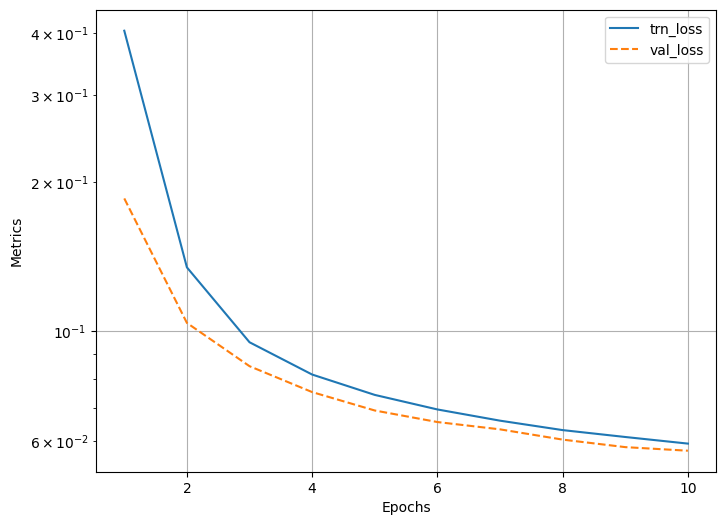

In [13]:
# visualize
log.plot_epochs(log=True)

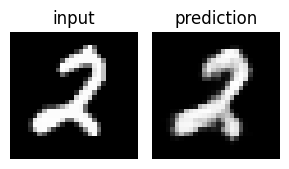

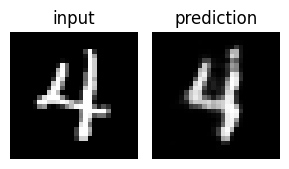

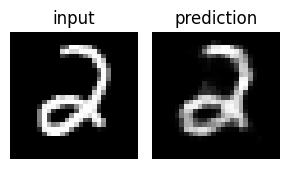

In [14]:
# Validate the model on the val_ds dataset (not provided during training)
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

## Grouping similar images (t-SNE)

In [23]:
latent_vectors = []
classes = []

In [24]:
# loop through images and store output of encoder layer
for im, clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)
    


In [25]:
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()


In [27]:
from sklearn.manifold import TSNE

In [28]:
tsne = TSNE(2)

In [29]:
clustered = tsne.fit_transform(latent_vectors)

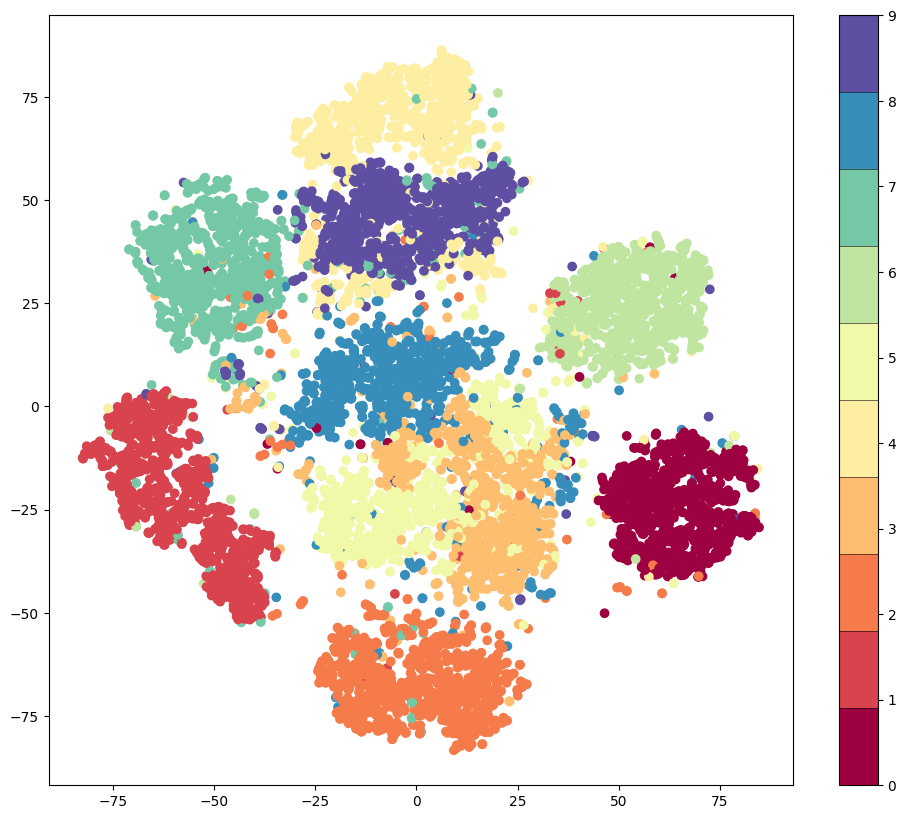

In [30]:
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)